https://towardsdatascience.com/multivariate-linear-regression-in-python-step-by-step-128c2b127171

https://www.mrlc.gov/data/legends/national-land-cover-database-2016-nlcd2016-legend

https://medium.com/analytics-vidhya/implementing-linear-regression-using-sklearn-76264a3c073c


In [1]:
# !pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', None)

In [3]:
catch_file = './Catchment Data/Catchment_Regression_Data.csv'
catch_data = pd.read_csv(catch_file)
catch_data = catch_data.drop(labels=['Roughness'],axis='columns')
print(len(catch_data))
catch_data.head()

37699


,CatchId,SLOPE,LENGTHKM,AREASQKM,StreamOrde,POINT_X,POINT_Y,AvgElev,RunoffC,MajLC
0,932020122,0.049157,4.754,6.0120,1.0,-75.185438,43.127256,205.3807,NaN,NaN
1,3246072,0.004730,2.260,1.6632,4.0,-74.565526,42.681145,371.1816,45.21915,81.0
2,3246388,0.000030,0.168,0.0378,3.0,-74.156619,42.612042,285.9409,43.21429,81.0
3,3247620,0.005577,0.624,1.0278,1.0,-74.116866,42.232266,716.3624,45.54291,43.0
4,3247570,0.009604,21.108,80.7237,1.0,-74.214211,42.256132,650.3924,41.60782,41.0


In [4]:
## Add corrections determined in Notebook 01.2
catch_data.loc[catch_data.CatchId == 6251308, 'SLOPE'] = 0.15 / 5223 # PASS1
catch_data.loc[catch_data.CatchId == 6251234, 'SLOPE'] = 0.36 / 6934 # PASS2 
catch_data.loc[catch_data.CatchId == 6251128, 'SLOPE'] = 1.27 / 1729 # PASS3
catch_data.loc[catch_data.CatchId == 6249784, 'SLOPE'] = 0.00005 # PASS7 - arbitrary because slope is almost zero
catch_data.loc[catch_data.CatchId == 6251122, 'SLOPE'] = 0.37 / (694 + 701) # PASS10
catch_data.loc[catch_data.CatchId == 6251144, 'SLOPE'] = 0.37 / (694 + 701) # PASS10
catch_data.loc[catch_data.CatchId == 6250358, 'SLOPE'] = 0.16 / 2744 # PASS16
catch_data.loc[catch_data.CatchId == 6250388, 'SLOPE'] = 0.71 / 3277 # PASS17
catch_data.loc[catch_data.CatchId == 6250418, 'SLOPE'] = 1.40 / 2824 # PASS18

catch_data.loc[catch_data.CatchId == 6246206, 'SLOPE'] = 1.59 / 2824 # WANQ2
catch_data.loc[catch_data.CatchId == 6250622, 'SLOPE'] = 1.41 / 2480 # POMP4/5
catch_data.loc[catch_data.CatchId == 6249738, 'SLOPE'] = 0.00005     # POMP2 - arbitrary value to remove error
# catch_data[catch_data.CatchId == 6246098, 'SLOPE'] = 0.88 / 1013 # RAMA5 - 
catch_data.loc[catch_data.CatchId == 932030072, 'SLOPE']=1.75 / 635  # RAMA5
catch_data.loc[catch_data.CatchId == 6250680, 'SLOPE'] = 0.00005     # ROCK2 - arbitrary value to remove error

# 020402
catch_data.loc[catch_data.CatchId == 4491888, 'SLOPE'] = 0.5 / 3571 # NBRAN4

catch_data.loc[catch_data.SLOPE < 0.00003, 'SLOPE'] = 0.00003

In [5]:
file1 = './HWM/Iter3/HWM_Combined_Opt.csv'
# print(file[:30])
rough_data1 = pd.read_csv(file1)
rough_data1 = rough_data1.drop_duplicates(subset='COMID')
rough_data1 = rough_data1.dropna(subset=['COMID'])
data1 = catch_data.merge(rough_data1[['COMID','roughness']], left_on='CatchId', right_on='COMID')
data1 = data1.drop(columns=['CatchId'])
print(len(data1))
data1.head()

190


,SLOPE,LENGTHKM,AREASQKM,StreamOrde,POINT_X,POINT_Y,AvgElev,RunoffC,MajLC,COMID,roughness
0,0.000612,5.019,8.6067,4.0,-74.102551,40.936324,20.04316,62.65450,22.0,6249688.0,0.027188
1,0.007341,0.331,0.9576,6.0,-74.180779,40.922627,40.65785,77.03477,23.0,6251026.0,0.022162
2,0.002241,1.352,1.0440,6.0,-74.221956,40.890790,48.53585,71.74138,23.0,6251124.0,0.010536
3,0.000030,0.985,0.8874,4.0,-74.078219,40.902936,14.68702,67.72820,22.0,6249812.0,0.008999
4,0.001855,1.887,2.3364,6.0,-74.153415,40.939709,19.30278,74.29314,23.0,932030163.0,0.010352


In [6]:
file2 = './HWM/Iter4_USGS/USGS_Opt.csv'

# print(file[:30])
rough_data2 = pd.read_csv(file2)
rough_data2 = rough_data2.drop_duplicates(subset='COMID')
rough_data2 = rough_data2.dropna(subset=['COMID'])

data2 = catch_data.merge(rough_data2[['COMID','roughness',]], left_on='CatchId', right_on='COMID')
data2 = data2.drop(columns=['CatchId'])
print(len(data2))
data2.head()

131


,SLOPE,LENGTHKM,AREASQKM,StreamOrde,POINT_X,POINT_Y,AvgElev,RunoffC,MajLC,COMID,roughness
0,0.022008,0.961,0.6426,6.0,-74.183398,40.912749,49.18388,70.19608,23.0,6251048,0.200000
1,0.000030,0.714,0.8109,6.0,-74.230063,40.880505,59.89762,65.97669,22.0,6250676,0.005000
2,0.000656,5.596,21.5631,6.0,-74.138098,40.899507,27.24430,73.41438,23.0,6251098,0.005000
3,0.000030,1.267,1.7118,5.0,-74.313445,40.865949,52.02080,75.44427,23.0,6250690,0.160339
4,0.003309,3.841,4.9347,4.0,-74.387943,40.899601,90.12553,52.77950,21.0,6249860,0.034440


In [7]:
data12 = data1.append(data2)
print(len(data12))
data12.head()

321


,SLOPE,LENGTHKM,AREASQKM,StreamOrde,POINT_X,POINT_Y,AvgElev,RunoffC,MajLC,COMID,roughness
0,0.000612,5.019,8.6067,4.0,-74.102551,40.936324,20.04316,62.65450,22.0,6249688.0,0.027188
1,0.007341,0.331,0.9576,6.0,-74.180779,40.922627,40.65785,77.03477,23.0,6251026.0,0.022162
2,0.002241,1.352,1.0440,6.0,-74.221956,40.890790,48.53585,71.74138,23.0,6251124.0,0.010536
3,0.000030,0.985,0.8874,4.0,-74.078219,40.902936,14.68702,67.72820,22.0,6249812.0,0.008999
4,0.001855,1.887,2.3364,6.0,-74.153415,40.939709,19.30278,74.29314,23.0,932030163.0,0.010352


-0.07707518197022067


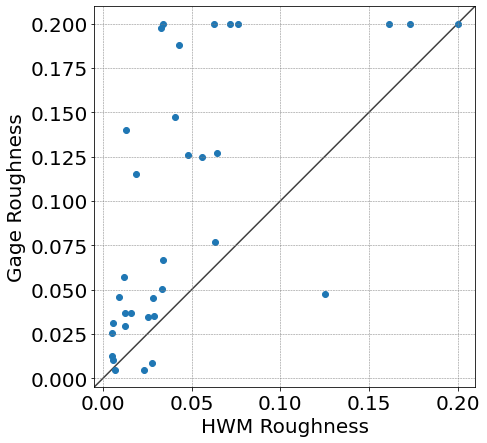

In [8]:
## Plot catchments with both HWM and USGS gage data
## Compare the different roughnesses - any conclusions?

dataI = data1.merge(data2[['COMID', 'roughness']], on='COMID')

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('axes', labelsize=20); matplotlib.rc('xtick', labelsize=20); matplotlib.rc('ytick', labelsize=20) 

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

# fig, ax = plt.subplots()
ax.scatter(x=dataI['roughness_x'], y=dataI['roughness_y'])

lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.set_xlim(lims); ax.set_ylim(lims)
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')

# ax.legend();
plt.xlabel("HWM Roughness"); plt.ylabel("Gage Roughness")
plt.grid(color = 'gray', linestyle='--',linewidth = 0.5)
plt.savefig('StreamDepth.png')
print(r2_score(dataI['roughness_y'], dataI['roughness_x']))

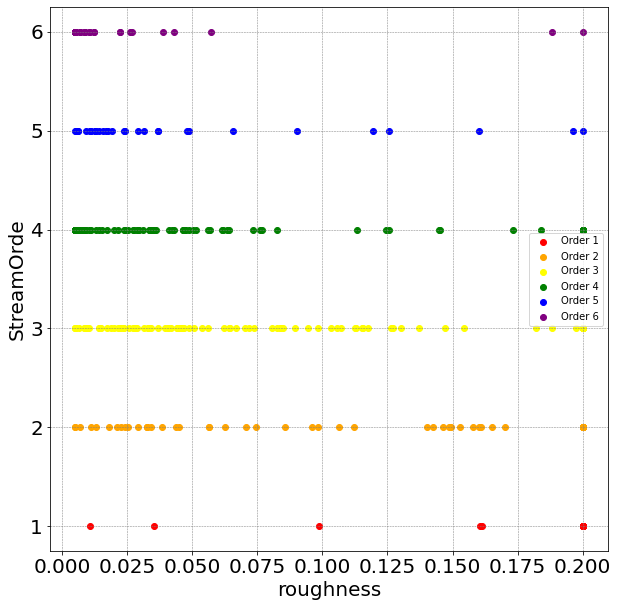

In [9]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('axes', labelsize=20) 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

# fig, ax = plt.subplots()
ax.scatter(x=data12['roughness'].loc[data12.StreamOrde==1], y=data12['StreamOrde'].loc[data12.StreamOrde==1],label='Order 1',c='red')
ax.scatter(x=data12['roughness'].loc[data12.StreamOrde==2], y=data12['StreamOrde'].loc[data12.StreamOrde==2],label='Order 2',c='orange')
ax.scatter(x=data12['roughness'].loc[data12.StreamOrde==3], y=data12['StreamOrde'].loc[data12.StreamOrde==3],label='Order 3',c='yellow')
ax.scatter(x=data12['roughness'].loc[data12.StreamOrde==4], y=data12['StreamOrde'].loc[data12.StreamOrde==4],label='Order 4',c='green')
ax.scatter(x=data12['roughness'].loc[data12.StreamOrde==5], y=data12['StreamOrde'].loc[data12.StreamOrde==5],label='Order 5',c='blue')
ax.scatter(x=data12['roughness'].loc[data12.StreamOrde==6], y=data12['StreamOrde'].loc[data12.StreamOrde==6],label='Order 6',c='purple')
ax.legend()
# lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
# now plot both limits against eachother
# ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
# ax.set_aspect('equal')
# ax.set_xlim(lims)
# ax.set_ylim(lims)
plt.xlabel("roughness")
plt.ylabel("StreamOrde")
plt.grid(color = 'gray', linestyle='--',linewidth = 0.5)
# plt.savefig('StreamDepth.png')


In [10]:
# catch = data12.drop_duplicates(subset='COMID')
# print("Order  Avg_H_m  Avg_rough  Avg_RMSE_m COMIDs  Pt_Count")
# for order in np.sort(catch.StreamOrde.unique()):
#     subset = catch.loc[catch.StreamOrde == order]
#     print(f'{order: 3}  {round(subset.Predict_Stream_H_m.mean(),1):5}  \
#     {round(subset.roughness.mean(),3):6}    {round(subset.rmse.mean(),2):7} {len(subset.COMID.unique()):7} \
#     {round(len(subset),1):7}')

# print("Order  Med_H_m  Med_rough  Med_RMSE_m  COMIDs  Pt_Count")
# for order in np.sort(catch.StreamOrde.unique()):
#     subset = catch.loc[catch.StreamOrde == order]
#     print(f'{order: 3}  {round(subset.Predict_Stream_H_m.median(),1):5}  \
#     {round(subset.roughness.median(),3):6}    {round(subset.rmse.median(),2):7} {len(subset.COMID.unique()):7} \
#     {round(len(subset),1):7}')

In [11]:
# data12d = data12.drop_duplicates(subset='COMID')

# data = data12d.copy()
data = data12.copy()
# data.describe()

In [12]:
data.dtypes

SLOPE         float64
LENGTHKM      float64
AREASQKM      float64
StreamOrde    float64
POINT_X       float64
POINT_Y       float64
AvgElev       float64
RunoffC       float64
MajLC         float64
COMID         float64
roughness     float64
dtype: object

In [13]:
## Where the roughness calibration results in 0.3 or 0.005, this is likely an error related to flows
## We drop these data
# data = data[data.roughness < 0.1999]
# data = data[data.roughness > 0.0051]

## Add a bias term  -  This didn't do anything so I took it out
# data = pd.concat([pd.Series(1, index=data.index, name='Bias'), data], axis=1)

## Convert data types into forms usable for regression
data.MajLC = data.MajLC.astype(str)
data.StreamOrde = data.StreamOrde.astype(str)

X = data.copy()
# X.dtypes

# X = X.drop(columns=['fmax','COMID','RMSE']) #, 'Avg_Lon','Avg_Lat'])   # all data but roughness is the input


# X = X.drop(columns=['roughness','COMID', 'MajLC'])  # 'MajLC' # all data but roughness is the input
# X = X.drop(columns=['roughness','COMID', 'MajLC','RunoffC','LENGTHKM','AREASQKM', 'SLOPE', 'POINT_X', 'POINT_Y', 'AvgElev'])
X = X.drop(columns=['roughness','COMID', 'POINT_X', 'POINT_Y','MajLC','RunoffC','LENGTHKM','AREASQKM',])  # 'MajLC' # all data but roughness is the input
# X
X.dtypes


SLOPE         float64
StreamOrde     object
AvgElev       float64
dtype: object

In [14]:
X = pd.get_dummies(data=X) # turns categorical data into a form that regression can interpret
X

,SLOPE,AvgElev,StreamOrde_1.0,StreamOrde_2.0,StreamOrde_3.0,StreamOrde_4.0,StreamOrde_5.0,StreamOrde_6.0
0,0.000612,20.043160,0,0,0,1,0,0
1,0.007341,40.657850,0,0,0,0,0,1
2,0.002241,48.535850,0,0,0,0,0,1
3,0.000030,14.687020,0,0,0,1,0,0
4,0.001855,19.302780,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
126,0.001125,42.721680,0,0,1,0,0,0
127,0.000084,4.163122,0,0,1,0,0,0
128,0.000964,20.531520,0,0,1,0,0,0
129,0.000804,31.471240,0,0,1,0,0,0


In [15]:
X.dtypes

SLOPE             float64
AvgElev           float64
StreamOrde_1.0      uint8
StreamOrde_2.0      uint8
StreamOrde_3.0      uint8
StreamOrde_4.0      uint8
StreamOrde_5.0      uint8
StreamOrde_6.0      uint8
dtype: object

In [16]:
# These are the available data columns
# Stream_H_m COMID StreamOrde fmax Predict_Stream_H_m roughness RMSE Majority_Land_Use \
# Avg_Lon Avg_Lat Avg_Elev RunoffC SLOPE LENGTHKM AREASQKM

y = data.roughness # only roughness is the target
# X

## Results from train/test split are highly dependent on random state
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #, random_state=5
# reg = LinearRegression().fit(X_train, y_train)
# print('Train Score = ' + str(round(reg.score(X_train, y_train),6)))
# print('Test  Score = ' + str(round(reg.score(X_test, y_test),6)))

reg = LinearRegression().fit(X, y)
print(f'All   Score = {str(round(reg.score(X, y),6))}\n')
predictA = reg.predict(X)
predictA[predictA < 0.005] = 0.005
predictA[predictA > 0.200] = 0.200

print(f'{round(reg.intercept_,6)} + ')
x=0
for i in reg.coef_:
    print(f'{round(i,6)} * {X.columns[x]} +')
#     if x == 0: print(" (Bias) ",end="")
#     if x > 0:  print(" * " + X.columns[x] + " ",end="")
#     print(" + ")
    x += 1

All   Score = 0.300702

0.074584 + 
4.766289 * SLOPE +
-0.000136 * AvgElev +
0.058332 * StreamOrde_1.0 +
0.031377 * StreamOrde_2.0 +
0.00962 * StreamOrde_3.0 +
-0.020435 * StreamOrde_4.0 +
-0.027396 * StreamOrde_5.0 +
-0.051499 * StreamOrde_6.0 +


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.3062170041699993


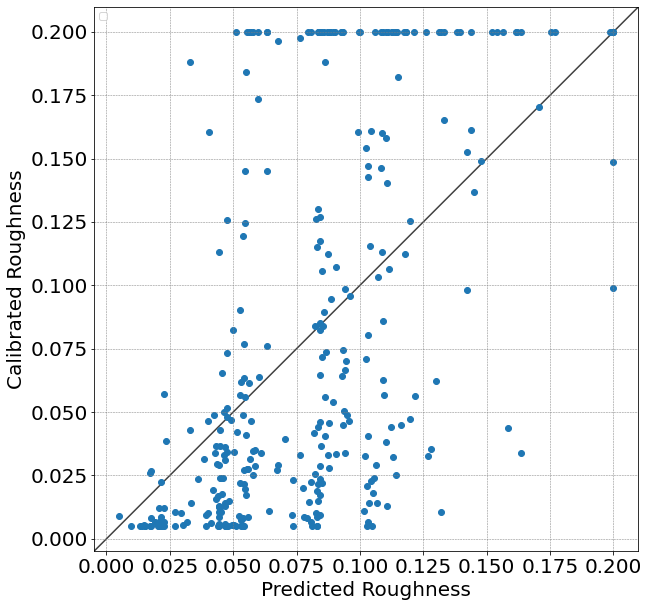

In [17]:
matplotlib.rc('axes', labelsize=20); matplotlib.rc('xtick', labelsize=20); matplotlib.rc('ytick', labelsize=20) 

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

# fig, ax = plt.subplots()
ax.scatter(x=predictA, y=y)

lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.set_xlim(lims); ax.set_ylim(lims)
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')

ax.legend(); plt.xlabel("Predicted Roughness"); plt.ylabel("Calibrated Roughness")
plt.grid(color = 'gray', linestyle='--',linewidth = 0.5)
plt.savefig('StreamDepth.png')

print(r2_score(y, predictA))

In [26]:
# This was an experiment in normalizing the data to determine the weight of each regression term
X2 = X.apply(lambda x: (x-x.min()) / (x.max()-x.min()) , axis=0)
X2

y2 = y/y.max()
reg2 = LinearRegression().fit(X2, y2)
print(f'All Score = {str(round(reg.score(X, y),6))}\n')

print(f'{round(reg2.intercept_,6)} + ')
x=0
for i in reg2.coef_:
    print(f'{round(i,6)} * {X2.columns[x]} + ')
#     if x == 0: print(" (Bias) ",end="")
#     if x > 0:  print(" * " + X.columns[x] + " ",end="")
#     print(" + ")
    x += 1

All Score = 0.388201

0.509464 + 
0.911001 * SLOPE + 
0.407989 * POINT_X + 
-0.74777 * POINT_Y + 
0.326828 * AvgElev + 
0.17272 * StreamOrde_1.0 + 
0.110545 * StreamOrde_2.0 + 
0.030845 * StreamOrde_3.0 + 
-0.093446 * StreamOrde_4.0 + 
-0.033069 * StreamOrde_5.0 + 
-0.187595 * StreamOrde_6.0 + 


In [27]:
data

,SLOPE,LENGTHKM,AREASQKM,StreamOrde,POINT_X,POINT_Y,AvgElev,RunoffC,MajLC,COMID,roughness
0,0.000612,5.019,8.6067,4.0,-74.102551,40.936324,20.043160,62.65450,22.0,6249688.0,0.027188
1,0.007341,0.331,0.9576,6.0,-74.180779,40.922627,40.657850,77.03477,23.0,6251026.0,0.022162
2,0.002241,1.352,1.0440,6.0,-74.221956,40.890790,48.535850,71.74138,23.0,6251124.0,0.010536
3,0.000030,0.985,0.8874,4.0,-74.078219,40.902936,14.687020,67.72820,22.0,6249812.0,0.008999
4,0.001855,1.887,2.3364,6.0,-74.153415,40.939709,19.302780,74.29314,23.0,932030163.0,0.010352
...,...,...,...,...,...,...,...,...,...,...,...
126,0.001125,1.546,6.7419,3.0,-74.959154,39.743754,42.721680,72.66520,90.0,9433571.0,0.200000
127,0.000084,1.192,1.1169,3.0,-74.824507,39.303889,4.163122,64.81467,90.0,9436435.0,0.200000
128,0.000964,6.939,7.6023,3.0,-74.846422,39.595722,20.531520,60.70498,90.0,9434145.0,0.200000
129,0.000804,6.926,17.1720,3.0,-74.911159,39.670703,31.471240,66.48009,90.0,9433603.0,0.200000


In [28]:
X

,SLOPE,POINT_X,POINT_Y,AvgElev,StreamOrde_1.0,StreamOrde_2.0,StreamOrde_3.0,StreamOrde_4.0,StreamOrde_5.0,StreamOrde_6.0
0,0.000612,-74.102551,40.936324,20.043160,0,0,0,1,0,0
1,0.007341,-74.180779,40.922627,40.657850,0,0,0,0,0,1
2,0.002241,-74.221956,40.890790,48.535850,0,0,0,0,0,1
3,0.000030,-74.078219,40.902936,14.687020,0,0,0,1,0,0
4,0.001855,-74.153415,40.939709,19.302780,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
126,0.001125,-74.959154,39.743754,42.721680,0,0,1,0,0,0
127,0.000084,-74.824507,39.303889,4.163122,0,0,1,0,0,0
128,0.000964,-74.846422,39.595722,20.531520,0,0,1,0,0,0
129,0.000804,-74.911159,39.670703,31.471240,0,0,1,0,0,0


In [29]:
# This is the data we will use for regression
# catch_data = catch_data.drop(columns=['Roughness'])
rdata = catch_data.copy()

# We are dropping the NaN data for simplicity at this time
rdata = rdata.fillna(-1)
rdata = rdata[rdata != -1]
rdata = rdata.dropna()
rdata = rdata[rdata.StreamOrde != -9]
# hucdata[hucdata.isna().any(axis=1)]
# hucdata[hucdata.isnull().any(axis=1)]

# Not all categorical data made it into the regression. Substitude unrepresented values with similars
rdata.loc[rdata.MajLC == 42, 'MajLC'] = 41
rdata.loc[rdata.MajLC == 43, 'MajLC'] = 41
rdata.loc[rdata.MajLC == 52, 'MajLC'] = 81
rdata.loc[rdata.MajLC == 71, 'MajLC'] = 81
rdata.loc[rdata.StreamOrde == 7, 'StreamOrde'] = 6

# Turn categories into strings. get_dummies turns categorical data into a form that regression can interpret
rdata.MajLC = rdata.MajLC.astype(str)
rdata.StreamOrde = rdata.StreamOrde.astype(str)

# Create the input for the regression. Must match the columns of regression data
rdata_in = rdata.drop(columns=['CatchId','MajLC','RunoffC','LENGTHKM','AREASQKM'])
rdata_in = pd.get_dummies(data=rdata_in)
predict = reg.predict(rdata_in)

# Write predictions to dataframe. Fit to bounds
rdata['Roughness'] = ''
rdata['Roughness'] = predict
rdata.loc[rdata['Roughness'] < 0.005, 'Roughness'] = 0.005
rdata.loc[rdata['Roughness'] > 0.200, 'Roughness'] = 0.200

# Create a df with just catchment and roughness. Merge back on to original rating curve table.
merge = rdata[['CatchId','Roughness']]
catch_data = catch_data.merge(merge, on='CatchId',how='left')
catch_data

# Fill roughness values where regression data was not available.
catch_data.Roughness = catch_data.Roughness.fillna(0.05)

# for catch in data.COMID.unique():
#     subset = data[data['COMID'] == catch]
#     # local_rough = opt['roughness'].loc[opt['COMID'] == catch][0]
#     local_rough = subset['roughness'].values[0]
#     catch_data.loc[catch_data['CatchId'] == catch, 'Roughness'] = local_rough
#     print('Rough at ' + str(catch) + ' is ' + str(local_rough))

In [30]:
catch_data

,CatchId,SLOPE,LENGTHKM,AREASQKM,StreamOrde,POINT_X,POINT_Y,AvgElev,RunoffC,MajLC,Roughness
0,932020122,0.049157,4.754,6.0120,1.0,-75.185438,43.127256,205.380700,NaN,NaN,0.050000
1,3246072,0.004730,2.260,1.6632,4.0,-74.565526,42.681145,371.181600,45.21915,81.0,0.005000
2,3246388,0.000030,0.168,0.0378,3.0,-74.156619,42.612042,285.940900,43.21429,81.0,0.005000
3,3247620,0.005577,0.624,1.0278,1.0,-74.116866,42.232266,716.362400,45.54291,43.0,0.143511
4,3247570,0.009604,21.108,80.7237,1.0,-74.214211,42.256132,650.392400,41.60782,41.0,0.145573
...,...,...,...,...,...,...,...,...,...,...,...
37694,27081103,0.000030,0.511,6.7689,1.0,-75.991480,36.823690,3.528421,69.97673,90.0,0.200000
37695,9889028,0.000030,0.051,0.0441,-9.0,-75.972696,36.832385,1.387905,84.69388,24.0,0.050000
37696,10466475,0.000030,0.633,2.0592,NaN,-75.979532,36.812708,3.343184,65.84790,21.0,0.050000
37697,10466473,0.000137,0.589,0.3654,NaN,-75.973918,36.824744,2.322969,66.19458,22.0,0.050000


In [32]:
f2 = catch_file[:-4] + '_dec27.csv'
catch_data.to_csv(f2,index=False)

In [33]:
hucs = ['020200', '020301','020401','020402','020403']

for huc in hucs:
    print(f'Starting {huc}...',end='')
    huc_path = 'H:/My Drive/' + huc + '/hydrogeo-fulltable-' + huc + '.csv'
    print('read...',end='')
    hucdata = pd.read_csv(huc_path)
    print('merge...',end='')
    hucdata = hucdata.merge(catch_data[['CatchId', 'Roughness']], on='CatchId')

    if huc == '020301':
        hucdata.loc[hucdata.CatchId == 6251308, 'SLOPE'] = 0.15 / 5223 # PASS1
        hucdata.loc[hucdata.CatchId == 6251234, 'SLOPE'] = 0.36 / 6934 # PASS2 
        hucdata.loc[hucdata.CatchId == 6251128, 'SLOPE'] = 1.27 / 1729 # PASS3
        hucdata.loc[hucdata.CatchId == 6249784, 'SLOPE'] = 0.00005 # PASS7 - arbitrary because slope is almost zero
        hucdata.loc[hucdata.CatchId == 6251122, 'SLOPE'] = 0.37 / (694 + 701) # PASS10
        hucdata.loc[hucdata.CatchId == 6251144, 'SLOPE'] = 0.37 / (694 + 701) # PASS10
        hucdata.loc[hucdata.CatchId == 6250358, 'SLOPE'] = 0.16 / 2744 # PASS16
        hucdata.loc[hucdata.CatchId == 6250388, 'SLOPE'] = 0.71 / 3277 # PASS17
        hucdata.loc[hucdata.CatchId == 6250418, 'SLOPE'] = 1.40 / 2824 # PASS18

        hucdata.loc[hucdata.CatchId == 6246206, 'SLOPE'] = 1.59 / 2824 # WANQ2
        hucdata.loc[hucdata.CatchId == 6250622, 'SLOPE'] = 1.41 / 2480 # POMP4/5
        hucdata.loc[hucdata.CatchId == 6249738, 'SLOPE'] = 0.00005     # POMP2 - arbitrary value to remove error
        # catch_data[catch_data.CatchId == 6246098, 'SLOPE'] = 0.88 / 1013 # RAMA5 - 
        hucdata.loc[hucdata.CatchId == 932030072, 'SLOPE']=1.75 / 635  # RAMA5
        hucdata.loc[hucdata.CatchId == 6250680, 'SLOPE'] = 0.00005     # ROCK2 - arbitrary value to remove error

    if huc == '020402':
        hucdata.loc[hucdata.CatchId == 4491888, 'SLOPE'] = 0.5 / 3571 # NBRAN4


    hucdata.loc[hucdata.SLOPE < 0.00003, 'SLOPE'] = 0.00003
    
    print('calc...',end='')
    hucdata['Discharge (m3s-1)'] = hucdata['WetArea (m2)'] * pow(hucdata['HydraulicRadius (m)'],2.0/3) * \
        pow(hucdata['SLOPE'],0.5) / hucdata['Roughness_y']
    
    print('write...',end='')
    hucdata.to_csv(huc_path[:-4] + '_regrDEC27.csv',index=False)
    print(f'complete!')
print('Finished!')

Starting 020200...read...merge...calc...write...complete!
Starting 020301...read...merge...calc...write...complete!
Starting 020401...read...merge...calc...write...complete!
Starting 020402...read...merge...calc...write...complete!
Starting 020403...read...merge...calc...write...complete!
Finished!
